In [19]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random

import jdgsim
from jdgsim import construct_initial_state
from jdgsim.integrators import leapfrog
from jdgsim.dynamics import direct_acc
from jdgsim.option_classes import SimulationConfig, SimulationParams
from jdgsim.initial_condition import Plummer_sphere
from jdgsim.utils import center_of_mass
from jdgsim.time_integration import time_integration

In [2]:
# Define the 
config = SimulationConfig(N_particles=1_000) #default values

params = SimulationParams(t_end = 0.01) #default values

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=False, numb_snapshots=10, fixed_timestep=True, integrator=0)
SimulationParams(G=4.498e-06, t_end=0.01)


: 

In [23]:
np.sqrt(potential)

NameError: name 'potential' is not defined

In [35]:
from multiprocessing import Pool    
import numpy as np

def generate_velocity_Plummer(potential_i, rejection_samples=1000):
        velocity_i = np.random.uniform(size=(rejection_samples, 3), low=-np.sqrt(-2*potential_i), high=np.sqrt(-2*potential_i))
        escape_velocity_mask = np.sum(velocity_i**2, axis=1) <= - 2*potential_i
        isotropic_velocity_mask = np.random.uniform(size=rejection_samples) <= ((0.5 * np.sum(velocity_i**2, axis=1) + potential_i ) / potential_i)**(7/2)
        return velocity_i[(escape_velocity_mask)&(isotropic_velocity_mask)][0]
    
def Plummer_sphere(mass, params, config,):
    Plummer_Mtot = np.sum(mass)
    r = np.sqrt( params.Plummer_a / (np.random.uniform(size=config.N_particles)**(-3/2) -1))
    phi = np.random.uniform(size=config.N_particles, low=0, high=np.pi) 
    sin_i = np.random.uniform(size=config.N_particles, low=-1, high=1)
    
    positions = np.array([r*np.cos(np.arcsin(sin_i))*np.cos(phi), r*np.cos(np.arcsin(sin_i))*np.sin(phi), r*sin_i]).T
    potential = - params.G * Plummer_Mtot / np.sqrt( np.linalg.norm(positions, axis=1)**2 + params.Plummer_a**2)
    with Pool(processes=1) as pool:
        velocities = pool.map(generate_velocity_Plummer, potential)
    return jnp.array(positions), jnp.array(velocities)

pos, velo = Plummer_sphere(np.array(mass), params, config)

/tmp/ipykernel_3565434/1541404409.py:7: RuntimeWarning: invalid value encountered in power
  isotropic_velocity_mask = np.random.uniform(size=rejection_samples) <= ((0.5 * np.sum(velocity_i**2, axis=1) + potential_i ) / potential_i)**(7/2)


(1000, 3)


In [ ]:
mass = jnp.ones(config.N_particles) 

#set up the particles in the initial state
position, velocity = Plummer_sphere(mass=mass, params=params, config=config)

#move the center to 10 Kpc distance from the center of the galaxy
position = position + jnp.array([10, 0, 0])

#initialize the initial state
initial_state = construct_initial_state(position, velocity)

#center of mass
com = center_of_mass(initial_state, mass)

/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
2025-02-03 17:35:38.696005: F external/xla/xla/stream_executor/cuda/cuda_context.cc:187] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
Status: INTERNAL: CUDA error: Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2025-02-03 17:35:38.702413: F external/xla/xla/stream_executor/cuda/cuda_context.cc:187] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
Status: INTERNAL: CUDA error: Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2025-02-03 17:35:38.708675: F external/xla/xla/stream_executor/cuda/cuda_context.cc:187] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
S

KeyboardInterrupt: 

: 

In [33]:
from jax.lax import while_loop

key = random.PRNGKey(0)
Plummer_Mtot = jnp.sum(mass)
r = jnp.sqrt( params.Plummer_a / (random.uniform(key, shape=config.N_particles)**(-3/2) -1))
phi = random.uniform(key, shape=config.N_particles, minval=0, maxval=jnp.pi) 
sin_i = random.uniform(key, shape=config.N_particles, minval=-1, maxval=1)

positions = jnp.array([r*jnp.cos(jnp.arcsin(sin_i))*jnp.cos(phi), r*jnp.cos(jnp.arcsin(sin_i))*jnp.sin(phi), r*sin_i]).T
potential = - params.G * Plummer_Mtot / jnp.sqrt( jnp.linalg.norm(positions, axis=1)**2 + params.Plummer_a**2)

def generate_velocity(key, potential_i):        
#     while True:
#         velocity_i = random.uniform(key, shape=3, minval=-jnp.sqrt(2*potential_i), maxval=jnp.sqrt(2*potential_i))
#         if jnp.sum(velocity_i**2) <= 2*potential_i:
#             u = random.uniform(key)
#             f = ((0.5 * jnp.sum(velocity_i**2) + potential_i ) / potential_i)**(7/2)
#             if u <= f:
#                 return velocity_i
            
    def cond_func(velocity_i):
        return (jnp.sum(velocity_i**2) > 2*potential_i)|(random.uniform(key) > ((0.5 * jnp.sum(velocity_i**2) + potential_i ) / potential_i)**(7/2) )
    def body_func(velocity_i):
        velocity_i = random.uniform(key, shape=3, minval=-jnp.sqrt(2*potential_i), maxval=jnp.sqrt(2*potential_i))
        return velocity_i
    initial_val = random.uniform(key, shape=3, minval=-jnp.sqrt(2*potential_i), maxval=jnp.sqrt(2*potential_i))
    while_loop(cond_fun=cond_func, body_fun=body_func, init_val=initial_val)

#     velocities = vmap(generate_velocity)(random.split(key, potential.shape), potential)

: 

In [4]:
final_state = time_integration(initial_state, mass, config, params)

/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/export/home/vgiusepp/miniconda3/envs/test_sstrax/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


: 

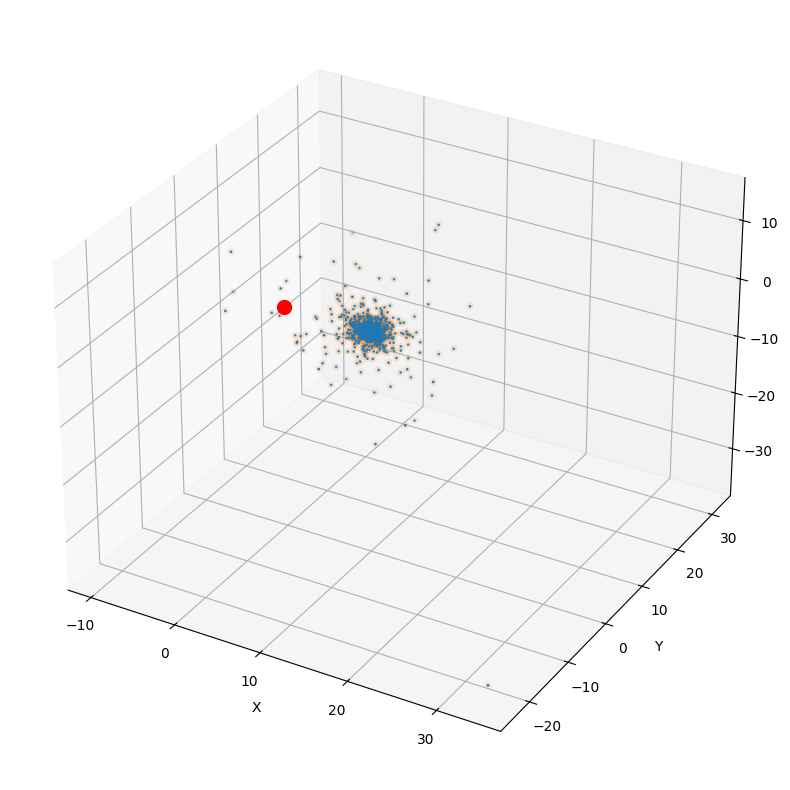

: 

In [5]:
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(position[:, 0], position[:, 1], position[:, 2], s=1)
ax.scatter(final_state[:, 0, 0], final_state[:, 0, 1], final_state[:, 0, 2], alpha=0.1)
ax.scatter(0, 0, 0, c='r', s=100)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.set_xlim(-20, 20)
# ax.set_ylim(-20, 20)
# ax.set_zlim(-20, 20)
plt.show()

In [6]:
final_state

Array([[[ 9.9119272e+00,  2.0773433e-01,  1.1938329e+00],
        [-1.0845507e+00, -2.1254387e-02, -1.3002366e-01]],

       [[ 1.0171013e+01,  1.5545788e-02, -5.2151125e-02],
        [-1.0842589e+00, -1.8775203e-03,  7.6264944e-03]],

       [[ 9.8358746e+00, -3.0692553e-02,  4.3727788e-01],
        [-1.1006258e+00,  1.8186248e-03, -4.9178481e-02]],

       ...,

       [[ 2.8127308e+00,  1.7389036e+00, -1.5124401e+00],
        [-1.2577077e+00, -7.7826560e-01,  6.7641693e-01]],

       [[ 9.5292463e+00,  6.3330156e-01,  5.4679412e-01],
        [-1.1142721e+00, -7.3512249e-02, -6.1896820e-02]],

       [[ 1.2423968e+01, -1.4295305e+00,  1.1397091e+00],
        [-9.4582933e-01,  1.0866420e-01, -8.5486270e-02]]], dtype=float32)

: 